In [0]:
! pip install neural_structured_learning scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import shutil

try:
    shutil.rmtree("fer13")
except Exception:
    pass

In [0]:
from zipfile import ZipFile 
  
file_name = "drive/My Drive/final_u1.zip"
  
with ZipFile(file_name, 'r') as zip_:
    print('Extracting all the files...') 
    zip_.extractall("fer13")
    print('Done!')

Extracting all the files...
Done!


In [0]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import neural_structured_learning as nsl

from keras.utils import np_utils

In [0]:
np.random.seed(42)

In [0]:
INPUT_PATH = "fer13/final/"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/NSL/"

In [0]:
class_count = {}
for dir_ in os.listdir(INPUT_PATH):
    if not dir_.isupper():
        os.rename(INPUT_PATH+dir_, INPUT_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Happy has 2477 number of images
Angry has 966 number of images
Sadness has 1326 number of images
Fear has 859 number of images
Neutral has 1446 number of images

total images are 7074


In [0]:
TOP_EMOTIONS = ["Happy", "Neutral", "Sadness", "Angry", "Fear"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

7074

In [0]:
img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(INPUT_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Sadness images to numpy arrays
loaded all Angry images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Fear images to numpy arrays
loaded all Neutral images to numpy arrays


((7074, 48, 48, 1), array([0., 0., 0., ..., 4., 4., 4.]))

In [0]:
label_to_text

{0: 'Sadness', 1: 'Angry', 2: 'Happy', 3: 'Fear', 4: 'Neutral'}

In [0]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Angry': 1, 'Fear': 3, 'Happy': 2, 'Neutral': 4, 'Sadness': 0}

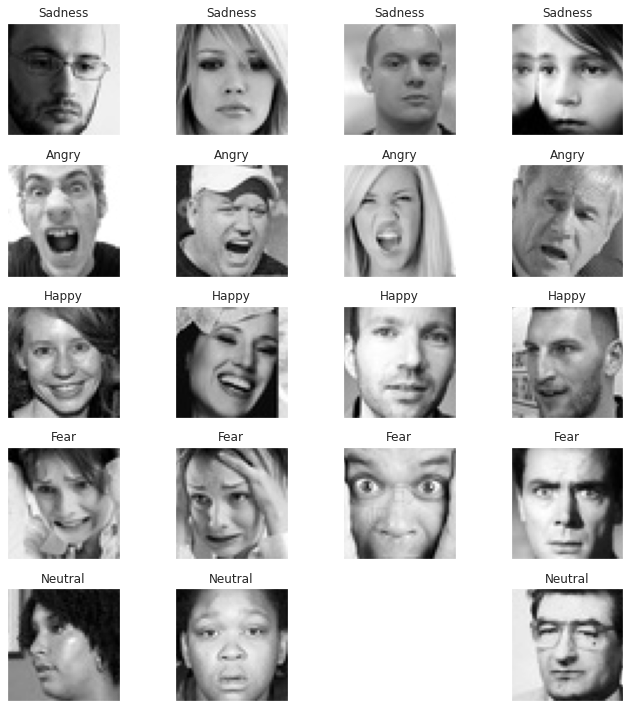

In [0]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [0]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(7074, 5)

In [0]:
img_arr = img_arr / 255.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.88, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6225, 48, 48, 1), (849, 48, 48, 1), (6225, 5), (849, 5))

In [0]:
IMAGE_INPUT_NAME = 'image_input'
LABEL_INPUT_NAME = 'label'

In [0]:
def build_base_model(input_shape, num_classes, show_summary=True):
    model_in = Input(shape=input_shape, name=IMAGE_INPUT_NAME)
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.35, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.5, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
        
    dense_1 = Dense(
        256,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.6, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")

    if show_summary:
        model.summary()
    
    return model

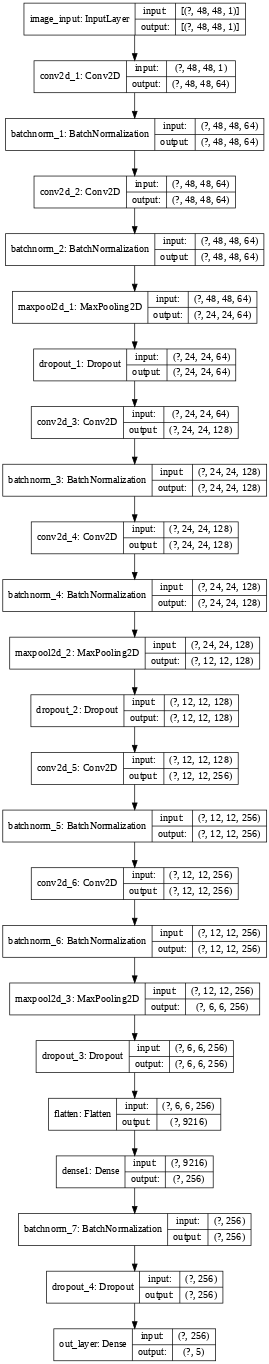

In [0]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

base_model = build_base_model(input_shape=(img_width, img_height, img_depth), num_classes=num_classes, show_summary=False)

plot_model(base_model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50, to_file=BASE_PATH+'nsl_basemodel.png')

I tried many different configurations of `multiplier` and `adv_step_size` and found below configurations as the best. You can see the results of all my runs [here](https://app.wandb.ai/gauravsharma/NSL?workspace=user-gauravsharma).

In [0]:
# tune adv_step in range [0.01, 0.1] & multiplier in range [0.1, 0.4]
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.5, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(base_model, adv_config=adv_config)

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [0]:
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0.00005,
    patience=7,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [0]:
def convert_to_dict_generator(image_data_gen):
    for image, label in image_data_gen:
        yield {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label} 

In [0]:
batch_size = 32
epochs = 40
optim = optimizers.Adam(0.001)

adv_model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# This is a hack to fix the error for tf-2.1, this is instructed by the tf community itself.
# You can read the issue thread for this, https://github.com/tensorflow/neural-structured-learning/issues/52
adv_model.evaluate({IMAGE_INPUT_NAME: X_test[:10], LABEL_INPUT_NAME: y_test[:10]})

history = adv_model.fit_generator(
    convert_to_dict_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size)),
    validation_data=tf.data.Dataset.from_tensor_slices({IMAGE_INPUT_NAME: X_test, LABEL_INPUT_NAME: y_test}).batch(batch_size),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

1/1 [==============================] - 0s 2ms/step - loss: 2.8823 - categorical_crossentropy: 1.8631 - categorical_accuracy: 0.2000 - adversarial_loss: 2.0384
Epoch 1/40
195/194 [==============================] - ETA: 0s - loss: 3.2558 - categorical_crossentropy: 2.1782 - categorical_accuracy: 0.2564 - adversarial_loss: 2.1552WARNING:tensorflow:Layer AdversarialRegularization is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

In [0]:
adv_model.save_weights(BASE_PATH+f"dumps/nsl_weights_{num_classes}emo.h5")
base_model.save(BASE_PATH+f"dumps/nsl_model_{num_classes}emo.h5")

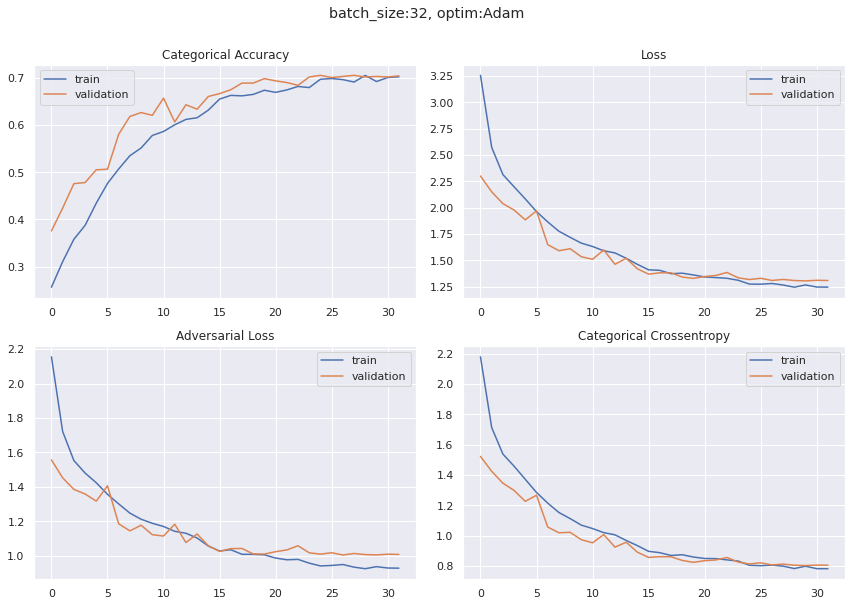

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 8))

ax = pyplot.subplot(2, 2, 1)
sns.lineplot(history.epoch, history.history['categorical_accuracy'], label="train")
sns.lineplot(history.epoch, history.history['val_categorical_accuracy'], label="validation")
pyplot.title('Categorical Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(2, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label="train")
sns.lineplot(history.epoch, history.history['val_loss'], label="validation")
pyplot.title('Loss')
pyplot.tight_layout()

ax = pyplot.subplot(2, 2, 3)
sns.lineplot(history.epoch, history.history['adversarial_loss'], label="train")
sns.lineplot(history.epoch, history.history['val_adversarial_loss'], label="validation")
pyplot.title('Adversarial Loss')
pyplot.tight_layout()

ax = pyplot.subplot(2, 2, 4)
sns.lineplot(history.epoch, history.history['categorical_crossentropy'], label="train")
sns.lineplot(history.epoch, history.history['val_categorical_crossentropy'], label="validation")
pyplot.title('Categorical Crossentropy')
pyplot.tight_layout()

pyplot.suptitle(f"batch_size:{batch_size}, optim:{optim.__class__.__name__}", y=1.05)
pyplot.savefig(BASE_PATH+f'epoch_metrics/nsl_{num_classes}emo.png')
pyplot.show()

In [0]:
label_to_text, text_to_label

({0: 'Sadness', 1: 'Angry', 2: 'Happy', 3: 'Fear', 4: 'Neutral'},
 {'Angry': 1, 'Fear': 3, 'Happy': 2, 'Neutral': 4, 'Sadness': 0})

test accuracy: 70.5536 %


              precision    recall  f1-score   support

           0       0.55      0.42      0.47       159
           1       0.66      0.75      0.70       116
           2       0.90      0.85      0.87       297
           3       0.67      0.58      0.62       103
           4       0.59      0.78      0.67       174

    accuracy                           0.71       849
   macro avg       0.67      0.67      0.67       849
weighted avg       0.71      0.71      0.70       849



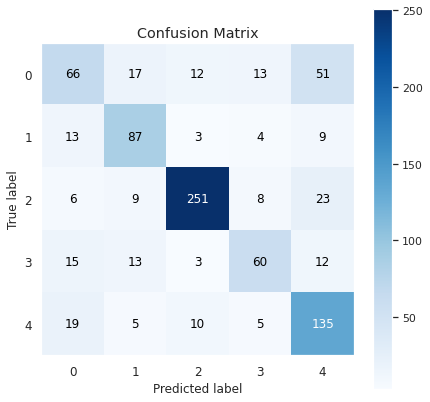

In [0]:
yhat_test = np.argmax(base_model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig(PLOTS_PATH+f"confusion_matrix/nsl_{num_classes}emo.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [0]:
yhat_train = np.argmax(base_model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

train accuracy: 76.3534 %


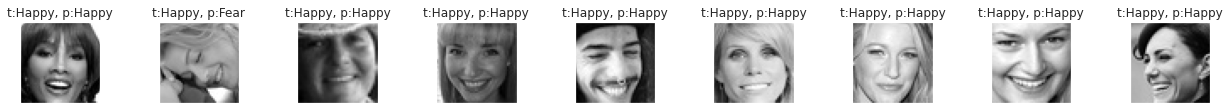

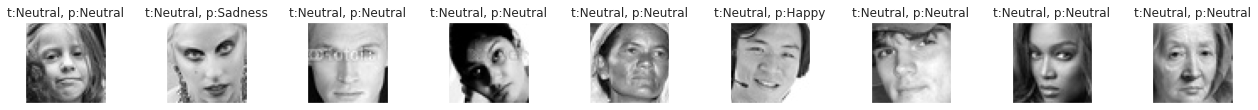

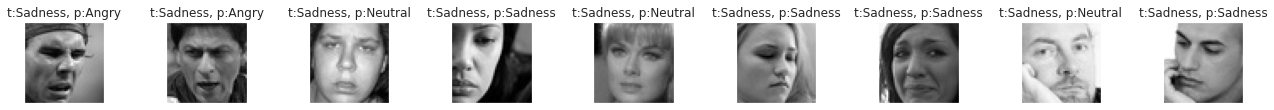

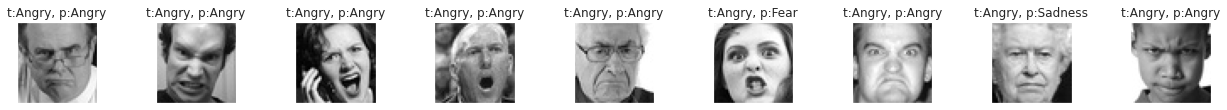

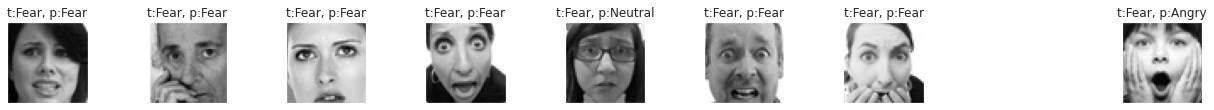

In [0]:
f = 1
for emotion in TOP_EMOTIONS:
    emotion_imgs = np.random.choice(np.where(y_test[:, text_to_label[emotion]]==1)[0], size=9, replace=False)

    pyplot.figure(f, (18,1.7))
    f += 1

    for i,img_idx in enumerate(emotion_imgs):
        sample_img = X_test[img_idx,:,:,0]
        pred = label_to_text[np.argmax(base_model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]
        ax = pyplot.subplot(1, 9, i+1)
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{emotion}, p:{pred}")
        pyplot.tight_layout()

In [0]:
def plot_miss_classified(emotion,fig):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    pyplot.figure(fig, (20, rows*1.5))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,0]
        pred = label_to_text[np.argmax(base_model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]
        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")
        pyplot.suptitle(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}", y=1, fontsize=16)

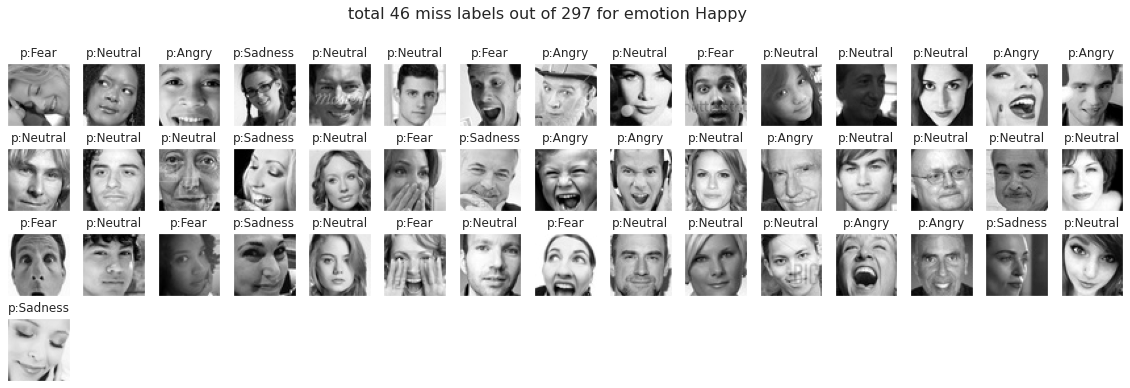

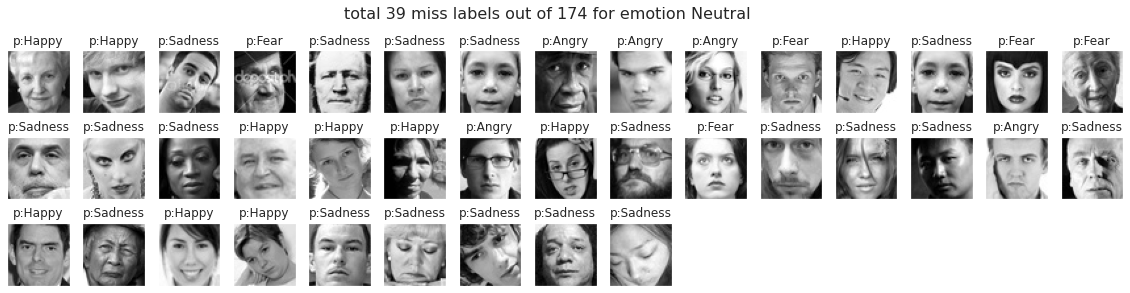

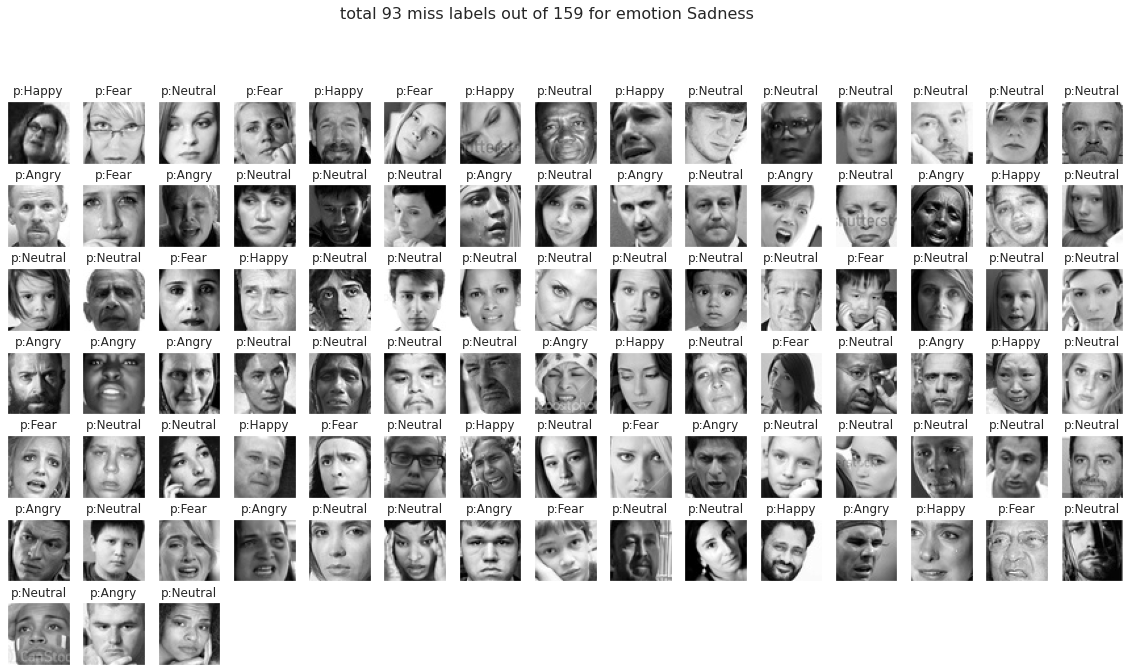

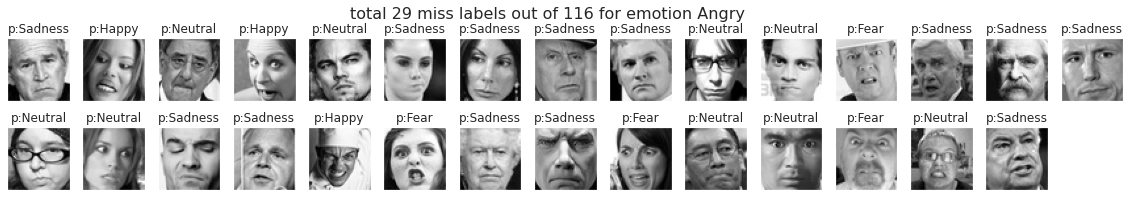

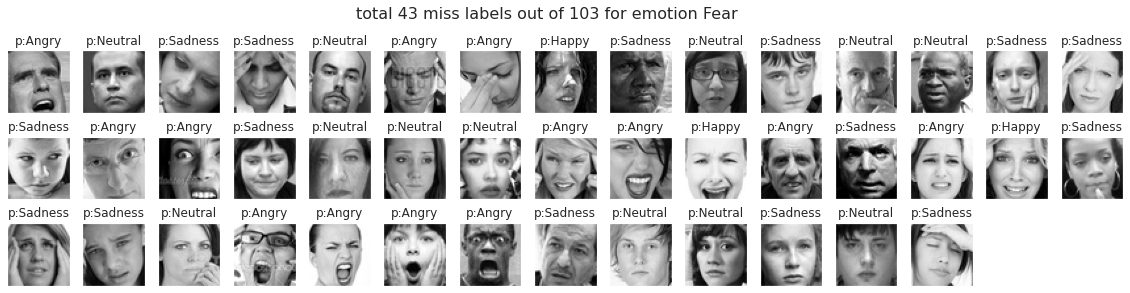

In [0]:
for fig,emotion in enumerate(TOP_EMOTIONS):
    plot_miss_classified(emotion, fig)

In [0]:
input_path = "drive/My Drive/FER/Colab/GauravSharma/leaderboard.csv"
leaderboard = pd.read_csv(input_path)

# increment the model number if you run a new set of configs
model_name = "nsl_dcnn" + "_3"

if not model_name in list(leaderboard.model):
    entries = {
        "model": model_name,
        "test_accu": test_accu,
        "train_accu": train_accu,
        "batch_size": batch_size,
        "optim": optim.__class__.__name__,
        "epochs": epochs,
        "num_emotion": num_classes,
        "emotions": ", ".join(TOP_EMOTIONS),
        "dataset": "fer_updated",
        "total_images": total_images,
    }
    leaderboard = leaderboard.append(entries, ignore_index=True)
    leaderboard = leaderboard.sort_values("test_accu", ascending=False, ignore_index=True)
    print("added to leaderboard\n")
else:
    print("model already exists in leaderboard\n")

leaderboard.to_csv(input_path, index=False)
leaderboard

added to leaderboard



,model,test_accu,train_accu,batch_size,optim,epochs,num_emotion,emotions,dataset,total_images
0,DCNN_1,78.095238,81.857545,20,Adam,80,3,"Happy, Neutral, Sadness",fer_updated,5249
1,DCNN_2,77.613941,82.921924,20,Adam,80,4,"Happy, Neutral, Sadness, Angry",fer_updated,6215
2,nsl_dcnn_1,76.984127,80.233817,16,Adam,40,3,"Happy, Neutral, Sadness",fer_updated,5249
3,imagenet_1,76.825397,79.389478,25,Adam,40,3,"Happy, Neutral, Sadness",fer_updated,5249
4,nsl_dcnn_2,74.530831,79.264948,24,Adam,40,4,"Happy, Neutral, Sadness, Angry",fer_updated,6215
5,DCNN_3,73.144876,79.823293,20,Adam,80,5,"Happy, Neutral, Sadness, Angry, Fear",fer_updated,7074
6,imagenet_2,71.983914,76.247943,25,Adam,40,4,"Happy, Neutral, Sadness, Angry",fer_updated,6215
7,nsl_dcnn_3,70.553592,76.353414,32,Adam,40,5,"Happy, Neutral, Sadness, Angry, Fear",fer_updated,7074
8,imagenet_3,69.964664,73.927711,25,Adam,40,5,"Happy, Neutral, Sadness, Angry, Fear",fer_updated,7074
